In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc
import glob
import imageio

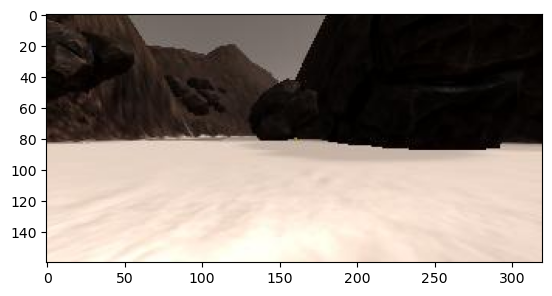

In [2]:
path = '../data/IMG/*'
img_list = glob.glob(path)
image = mpimg.imread(img_list[0])
plt.imshow(image)

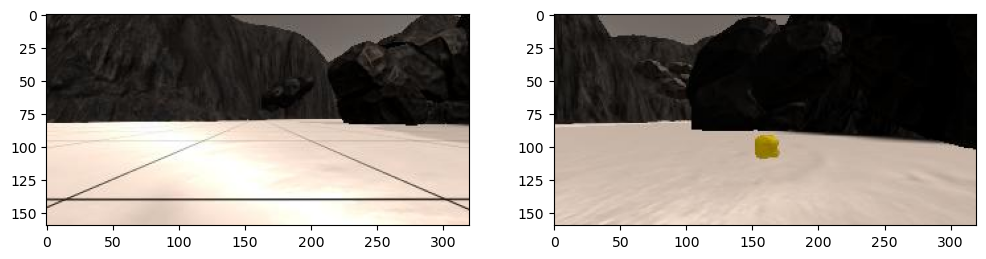

In [3]:
example_grid = "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"
example_thresh = "../calibration_images/example_rock2.jpg"
example3 = "../data/IMG/robocam_2022_12_03_21_19_28_019.jpg"
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)
rock1_img = mpimg.imread(example_thresh)
rock2_img = mpimg.imread(example3)


fig = plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

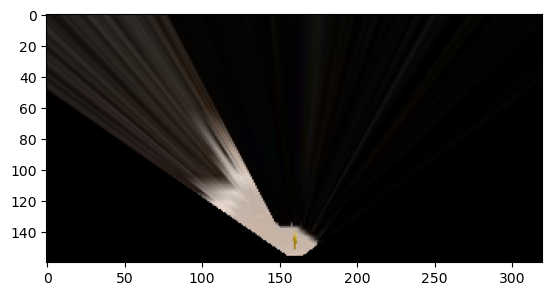

In [4]:
def perspect_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped


dst_size = 5
bottom_offset = 5
source = np.float32([[14,140],
                     [300,140],
                     [200,95],
                     [120,95]])

destination = np.float32([[image.shape[1] / 2 - dst_size, image.shape[0] - bottom_offset],
                          [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                          [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                          [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset]])

image_transform = perspect_transform(rock_img, source, destination)

plt.imshow(image_transform)

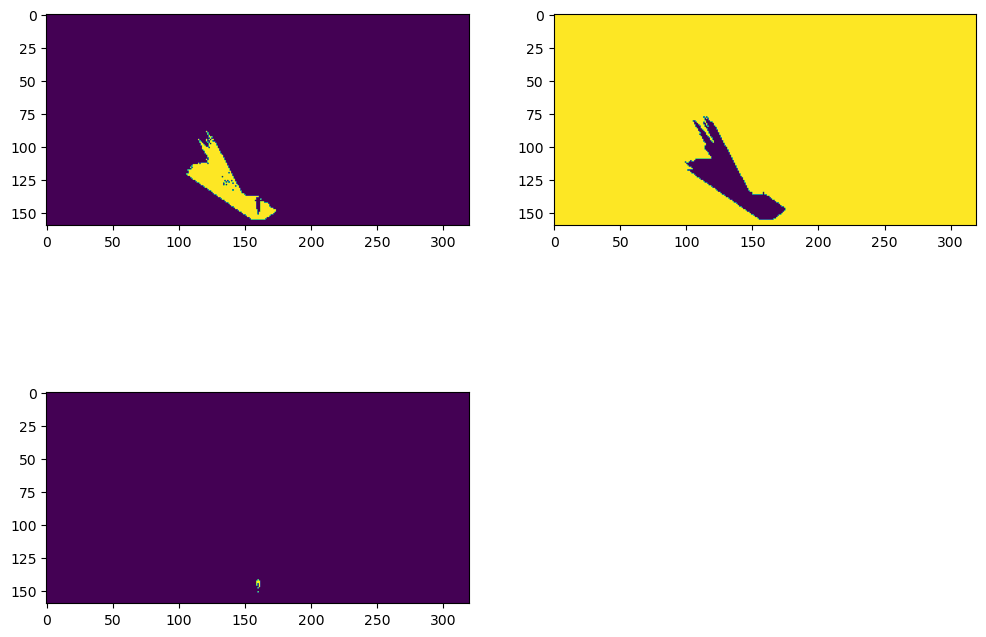

In [5]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    #200,200,3
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

def color_thresh_obs(img, rgb_thresh=(120, 120, 120)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

# Identify yellow rock sample
def color_thresh_rock(img):
    # yellow_hsv = [30,255,255] # H is 0-179 degree not 360
    # convert RGB image to HSV image
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # define lowerbound and upperbound for yellow color
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    # detect color in image by masking pixels
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    result = cv2.bitwise_and(img, img, mask=mask)
    # convert result to binary
    binary_result = color_thresh(result, (0, 0, 0))
    # return binary result
    return binary_result


    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
nav_train = color_thresh(image_transform,(160,160,160))
 
obs       = color_thresh_obs(image_transform,(120,120,120))#145,115,1
rock      = color_thresh_rock(image_transform)
    
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(nav_train)
plt.subplot(222)
plt.imshow(obs)
plt.subplot(223)
plt.imshow(rock)

/tmp/ipykernel_5432/3025477744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
/tmp/ipykernel_5432/3025477744.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img.shape[1]/2).astype(np.float)


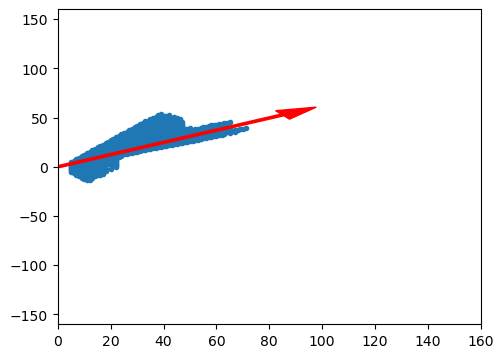

In [7]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()  #points bt3t ay lon fi el sora
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)  #bngib distance bel square root
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world



nav_train_roverx,nav_train_rovery = rover_coords(nav_train)



nav_dists,nav_angles = to_polar_coords(nav_train_roverx, nav_train_rovery)

mean_dir = np.mean(nav_angles)
    
# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.plot(nav_train_roverx, nav_train_rovery, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)